# Ramps functional spectrum

**Pre-requisite: Polarization**

This notebook describes the parameterization for ramps.  

The complete documentation of the individual functions can be found on the [API documentation website](https://doc.zahner.de/zahner_potentiostat/index.html).

Ramps can be customized with 3 different ways:
1. [**measureRampValueInTime()**](https://doc.zahner.de/zahner_potentiostat/scpi_control/control.html#zahner_potentiostat.scpi_control.control.SCPIDevice.measureRampValueInTime)  
Ramp from actual value to a target value is executed within a specified time.

2. [**measureRampValueInScanRate()**](https://doc.zahner.de/zahner_potentiostat/scpi_control/control.html#zahner_potentiostat.scpi_control.control.SCPIDevice.measureRampValueInScanRate)  
Ramp from actual value to a target value is executed with a defined slew (scan) rate.

3. [**measureRampScanRateForTime()**](https://doc.zahner.de/zahner_potentiostat/scpi_control/control.html#zahner_potentiostat.scpi_control.control.SCPIDevice.measureRampScanRateForTime)  
Ramp is executed at a defined slew rate from actual value for a defined time. The user must pay special attention to the chosen defined time. With unusually long measurement time, the system under investigation may exit the safe operation conditions.

In the following, a 18650 lithium-manganese battery (Samsung ICR18650-26JM) with a capacity of 2.6 Ah is used as a test object.  

The battery is connected to the power potentiostat as shown in the [power potentiostat manual](https://zahner.de/media-files/downloads_pdf/files/power_potentiostats.pdf#page=20), page 16. This scheme allows a positive open circuit voltage. 

The measurements carried out in this notebook do not necessarily have to make sense from an electrochemical point of view. The only purpose they serve is to explain the configuration of primitives and their different applications.

In [1]:
from zahner_potentiostat.scpi_control.searcher import SCPIDeviceSearcher
from zahner_potentiostat.scpi_control.serial_interface import SerialCommandInterface, SerialDataInterface
from zahner_potentiostat.scpi_control.control import *
from zahner_potentiostat.scpi_control.datahandler import DataManager
from zahner_potentiostat.scpi_control.datareceiver import TrackTypes
from zahner_potentiostat.display.onlinedisplay import OnlineDisplay

from jupyter_utils import executionInNotebook
if __name__ == '__main__':
    deviceSearcher = SCPIDeviceSearcher()
    deviceSearcher.searchZahnerDevices()
    commandSerial, dataSerial = deviceSearcher.selectDevice()
    ZahnerPP2x2 = SCPIDevice(SerialCommandInterface(commandSerial), SerialDataInterface(dataSerial))
    ZahnerPP2x2.clearState()

COM10:
ZAHNER-ELEKTRIK,PP212,33000,1.0.0 binary

COM9:
ZAHNER-ELEKTRIK,PP212,33000,1.0.0



# Setting general parameters
First of all, general parameters are set, which will be used in all primitives.

A note for users who previously worked with the power potentiostats only via Thales as EPC device:

The power potentiostat's voltage ranges varies depending on EPC operation, i.e., the power potentiostat is connected to a Zennium series potentisotat and controlled via Thales, or the power potentiostat is being operated in stand-alone mode and controlled via Zahner-Lab. In Thales operation, the voltage range with index 1 would be necessary for the battery (with voltage of 4.2 V), since range 0 only reaches up to 4 V (for PP242/PP222 and XPOT2).

In [ ]:
    ZahnerPP2x2.setRaiseOnErrorEnabled(True)
    ZahnerPP2x2.calibrateOffsets()
    ZahnerPP2x2.setSamplingFrequency(10)
    
    ZahnerPP2x2.setAutorangingEnabled(True)
    ZahnerPP2x2.setInterpolationEnabled(True)
    
    ZahnerPP2x2.setShuntIndex(1)
    ZahnerPP2x2.setVoltageRangeIndex(0)

# Set current and voltage limits

The battery is discharged at 2 C and charged at 1 C.

The current and voltage limits are set somewhat more liberally, as the primitives will be immediately aborted (high priority) if they cross the defined limits. If the limits are set to the voltage/current values which we want to measure then as soon as the defined limit will be reached the measurement will be terminated.

The voltage limits are always absolute values and **not** relative to the OCV (OCV is the same as OCP).

If these limits are exceeded, the potentiostat is switched off and the power potentiostats assumes an error state.

With ZahnerPP2x2.[clearState()](https://doc.zahner.de/zahner_potentiostat/scpi_control/control.html#zahner_potentiostat.scpi_control.control.SCPIDevice.clearState) this error state could be cleared again, so that primitives can be executed further. If an attempt is made to execute further primitives in the error state, an error message is displayed.

In [ ]:
    ZahnerPP2x2.setMinimumCurrentGlobal(-8)
    ZahnerPP2x2.setMaximumCurrentGlobal(4)
    ZahnerPP2x2.setGlobalCurrentCheckEnabled(True)
    
    ZahnerPP2x2.setMinimumVoltageGlobal(3.0)
    ZahnerPP2x2.setMaximumVoltageGlobal(4.25)
    ZahnerPP2x2.setGlobalVoltageCheckEnabled(True)
    
    ZahnerPP2x2.setGlobalLimitCheckToleranceTime(1)

# Starting the live data display

With the following command, a plotting window can be opened, in which the measured voltage and current points from the measuring device are displayed live.


The function executionInNotebook() is used to check if the execution is taking place in Jupyter notebook or not. As Jupyter cannot display the live measured data so if the execution take place in Jupyter notebook then the online display will not be executed.

In [4]:
    onlineDisplay = None
    if executionInNotebook() == False:
        onlineDisplay = OnlineDisplay(ZahnerPP2x2.getDataReceiver())

# Potentiostatic ramps at the OCV voltage

Ramps are started at the OCV and driven to a maximum of 4.2 V or 1 C current, whichever occurs sooner. Subsequently, a ramp is started in the opposite direction, to a minimum of 3.0 V or -2 C current. Afterwards, a ramp is run back to the initial OCV voltage.  

## Setting the measurement on the OCV

In order to measure with a defined potential, potentiostatic operation is set first.

In [ ]:
    ZahnerPP2x2.setCoupling(COUPLING.POTENTIOSTATIC)

Then it is necessary to set the voltage parameters. The first command [setVoltageRelation()](https://doc.zahner.de/zahner_potentiostat/scpi_control/control.html#zahner_potentiostat.scpi_control.control.SCPIDevice.setVoltageRelation) sets the voltage value which is defined in [setVoltageValue()](https://doc.zahner.de/zahner_potentiostat/scpi_control/control.html#zahner_potentiostat.scpi_control.control.SCPIDevice.setVoltageValue).  
With [setVoltageValue()](https://doc.zahner.de/zahner_potentiostat/scpi_control/control.html#zahner_potentiostat.scpi_control.control.SCPIDevice.setVoltageValue) or [setCurrentValue()](https://doc.zahner.de/zahner_potentiostat/scpi_control/control.html#zahner_potentiostat.scpi_control.control.SCPIDevice.setCurrentValue) the voltage or current values are set, which are to be outputted when the potentiostat is switched on without starting a measuring primitive. In this state, voltage and current are not monitored. Only by the start of a primitives the monitoring of voltage or current, as well as autoranging, takes place.

The second command [setVoltageParameterRelation()](https://doc.zahner.de/zahner_potentiostat/scpi_control/control.html#zahner_potentiostat.scpi_control.control.SCPIDevice.setVoltageParameterRelation) sets the parameter defined in [setVoltageParameter()](https://doc.zahner.de/zahner_potentiostat/scpi_control/control.html#zahner_potentiostat.scpi_control.control.SCPIDevice.setVoltageParameter). This command tells the power potentiostat the voltage or current parameter needed in potentiostatic or galvanostatic methods.

With [RELATION.ZERO](https://doc.zahner.de/zahner_potentiostat/scpi_control/control.html#zahner_potentiostat.scpi_control.control.RELATION) it is defined that absolute voltages are concerned.

In the next subsection, with the command [measureOCV()](https://doc.zahner.de/zahner_potentiostat/scpi_control/control.html#zahner_potentiostat.scpi_control.control.SCPIDevice.measureOCV) the open circuit voltage is defined, to which the voltage values refer.

In [ ]:
    ZahnerPP2x2.setVoltageRelation(RELATION.OCV)
    ZahnerPP2x2.setVoltageParameterRelation(RELATION.ZERO)

## Setting the start voltage

Ramps always start at the actual voltage or current value.

This means that user must set the actual voltage with [setVoltageValue()](https://doc.zahner.de/zahner_potentiostat/scpi_control/control.html#zahner_potentiostat.scpi_control.control.SCPIDevice.setVoltageValue) or actual current with [setCurrentValue()](https://doc.zahner.de/zahner_potentiostat/scpi_control/control.html#zahner_potentiostat.scpi_control.control.SCPIDevice.setCurrentValue) under the following conditions:
* No primitive has been output yet
* The coupling is changed from potentiostatic to galvanostatic or vice versa.

For example, if potentiostatic [measurePolarization()](https://doc.zahner.de/zahner_potentiostat/scpi_control/control.html#zahner_potentiostat.scpi_control.control.SCPIDevice.measurePolarization) is applied before the potentiostatic ramp, then the potentiostatic ramp starts to apply the polarization voltage after the polarization.

If, for example, an OCP scan [measureOCVScan()](https://doc.zahner.de/zahner_potentiostat/scpi_control/control.html#zahner_potentiostat.scpi_control.control.SCPIDevice.measureOCVScan) or a galvanostatic polarization is applied before the ramp instead of the potentiostatic polarization, then the actual voltage must be set with setVoltageValue after the OCP scan or galvanostatic polarization.  

The user must explicitly define each and every parameter required for the measurement. Not defining every parameter may result in error.

After the ramp measurement, the potentiostat is returned to the same condition as before the measurement. If the potentiostat was on before the measurement, then it remains on after the measurement and vice versa.

In [7]:
    openCircuitVoltage = ZahnerPP2x2.measureOCV()
    print("open circuit reference voltage: " + str(openCircuitVoltage) + " V")

open circuit reference voltage: 3.8172209693263857 V


Then the command [setVoltageValue(0)](https://doc.zahner.de/zahner_potentiostat/scpi_control/control.html#zahner_potentiostat.scpi_control.control.SCPIDevice.setVoltageValue) sets the OCP value as the starting voltage value. This is similar to the command [setVoltageRelation((RELATION.OCV)](https://doc.zahner.de/zahner_potentiostat/scpi_control/control.html#zahner_potentiostat.scpi_control.control.SCPIDevice.setVoltageRelation), which was used to set OCV as the reference.

In [ ]:
    ZahnerPP2x2.setVoltageValue(0)

## Setting the current limits

Since the ramps should only go up to the current limits and then the functional aborts of the primitive should be used, the limits are set first and then the functional aborts are switched on with the methods [setMinMaxCurrentParameterCheckEnabled()](https://doc.zahner.de/zahner_potentiostat/scpi_control/control.html#zahner_potentiostat.scpi_control.control.SCPIDevice.setMinMaxCurrentParameterCheckEnabled).

In [ ]:
    BatteryC = 2.6
    ZahnerPP2x2.setMinimumCurrentParameter(-2.0 * BatteryC)
    ZahnerPP2x2.setMaximumCurrentParameter(1.0 * BatteryC)
    ZahnerPP2x2.setParameterLimitCheckToleranceTime(0.5)
    ZahnerPP2x2.setMinMaxCurrentParameterCheckEnabled(True)


## Execute the primitives

Since the ramp may take different measurement times depending on how much voltage is needed to reach the current limit, the ramp [measureRampValueInScanRate()](https://doc.zahner.de/zahner_potentiostat/scpi_control/control.html#zahner_potentiostat.scpi_control.control.SCPIDevice.measureRampValueInScanRate) is used so as to keep the slew rate constant.  

A scan rate of 10 mV/s is set with the method [setScanRateParameter()](https://doc.zahner.de/zahner_potentiostat/scpi_control/control.html#zahner_potentiostat.scpi_control.control.SCPIDevice.setScanRateParameter).

In [ ]:
    ZahnerPP2x2.setScanRateParameter(0.010)

Now the primitives can be executed.  
The ramp is first run in the charging direction to 4.2 V, and then in the discharging direction to 3.0 V.

In [ ]:
    ZahnerPP2x2.measureRampValueInScanRate(targetValue = 4.2)
    ZahnerPP2x2.measureRampValueInScanRate(targetValue = 3.0)

After the ramp up and down, there is an additional ramp back to the OCV where the measurement was started.  
For this purpose, the relation of the voltage parameter is changed to OCV voltage with the method [setVoltageParameterRelation(RELATION.OCV)](https://doc.zahner.de/zahner_potentiostat/scpi_control/control.html#zahner_potentiostat.scpi_control.control.SCPIDevice.setVoltageParameterRelation).

In [ ]:
    ZahnerPP2x2.setVoltageParameterRelation(RELATION.OCV)

Here, the ramp is started with the target voltage 0 V, since the target voltage now refers to the open circuit voltage.

In [ ]:
    ZahnerPP2x2.measureRampValueInScanRate(targetValue =  0.0)

## Plot the data

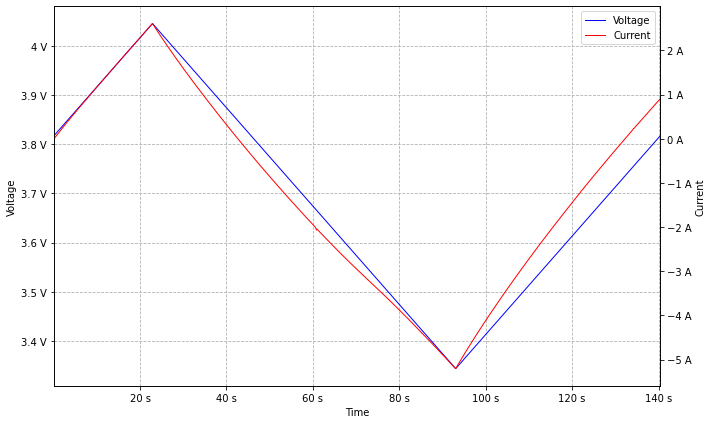

<Figure size 432x288 with 0 Axes>

In [14]:
    dataReceiver = ZahnerPP2x2.getDataReceiver()
    dataManager = DataManager(dataReceiver)
    dataManager.plotTIUData()

# Close the connection

Closing the online display if it has been opened and close the connection to the power potentiostat.

In [15]:
    if onlineDisplay != None:
        onlineDisplay.close()
    
    ZahnerPP2x2.close()
    print("finish")

finish
